In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import keras.utils
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [139]:
#import our dataset with sunspot data
df = pd.read_csv('sunspots.csv', sep=';')
df.tail(10)

,Date (month) / Date (mois),Year / Année,Month / Mois,Date in fraction of year / Date en fraction de l'année,Monthly mean total sunspot number,Monthly mean / Moyenne mensuelle,Number of observations / Nombre d'observations,Definitive or provisional value / Valeur définitive ou provisoire
3293,2021-10,2021,10,2021.790,37.4,8,1347,1
3294,2021-12,2021,12,2021.958,67.5,15,845,1
3295,2022-04,2022,4,2022.286,84.0,15,1376,1
3296,2022-06,2022,6,2022.453,70.3,13,1403,1
3297,2022-07,2022,7,2022.538,91.4,12,1487,1
3298,2022-12,2022,12,2022.958,112.8,16,860,1
3299,2023-04,2023,4,2023.286,97.6,18,1132,1
3300,2023-06,2023,6,2023.453,160.5,20,1248,1
3301,2023-12,2023,12,2023.958,113.5,17,785,1
3302,2024-01,2024,1,2024.042,123.0,18,783,0


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 8 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Date (month) / Date (mois)                                         3303 non-null   object 
 1   Year / Année                                                       3303 non-null   int64  
 2   Month / Mois                                                       3303 non-null   int64  
 3   Date in fraction of year / Date en fraction de l'année             3303 non-null   float64
 4   Monthly mean total sunspot number                                  3303 non-null   float64
 5   Monthly mean / Moyenne mensuelle                                   3303 non-null   int64  
 6   Number of observations / Nombre d'observations                     3303 non-null   int64  
 7   Definitive or provisional

In [141]:
df.rename(columns={'Date in fraction of year / Date en fraction de l\'année': 'Year'}, inplace=True)
df = df[['Year', 'Monthly mean total sunspot number']]

In [142]:
df['Year']=df['Year']-1749.042

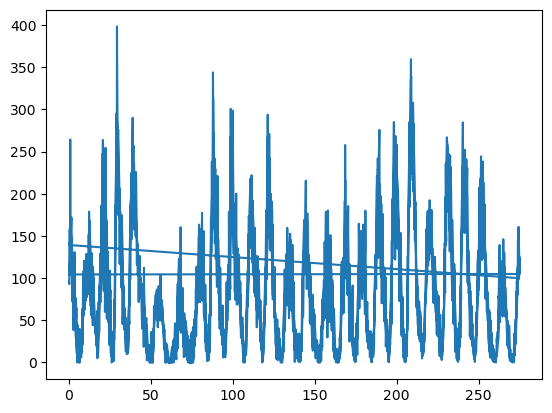

In [143]:
plt.plot(df['Year'], df['Monthly mean total sunspot number'])
plt.show()

In [151]:
df_arr = df['Monthly mean total sunspot number'].values

In [152]:
df_arr.shape

(3303,)

In [155]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df_arr.reshape(-1, 1))

In [156]:
data.shape

(3303, 1)

In [159]:
def build_window(data, h, f):
    
    dataX, dataY = [], []
    
    for i in range(len(data)-h-f):
        dataX.append(data[i:(i+h)])
        dataY.append(data[(i+h):(i+h+f)])
        
    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    
    dataY = np.array(dataY)
    
    return dataX, dataY

In [160]:
history_length = 12
forecast_length = 36

dataX, dataY = build_window(df_arr, history_length, forecast_length)
data.shape, dataX.shape, dataY.shape

((3303, 1), (3255, 1, 12), (3255, 36))

In [161]:
num_train_samples = int(0.8 * len(data))
trainX, trainY = dataX[:num_train_samples,:,:], dataY[:num_train_samples,:]
valX,  valY    = dataX[num_train_samples:,:,:], dataY[num_train_samples:,:]
trainX.shape, trainY.shape, valX.shape,  valY.shape

((2642, 1, 12), (2642, 36), (613, 1, 12), (613, 36))

In [176]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1,12)))
model_lstm.add(Dense(24))

2024-05-21 21:55:11.517108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-21 21:55:11.517517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-21 21:55:11.517976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [177]:
model.compile(loss='mse', metrics=["mae"])

history = model.fit(trainX, trainY, 
                 epochs=100, 
                 batch_size=32, 
                 validation_data = (valX, valY) )

Epoch 1/100


ValueError: in user code:

    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/stephenthorpe/anaconda3/envs/tf/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 12, 1), found shape=(None, 1, 12)


In [178]:
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_numunits, input_shape=(1, history_length)))
model_lstm.add(Dense(forecast_length))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (valX, valY),
                         verbose=0)

model_lstm.summary()

NameError: name 'lstm_numunits' is not defined